In [104]:
import os.path
from scipy import interpolate
import yaml
import matplotlib.pyplot as plt
import numpy as np

In [105]:
datasets = ["cifar10", "cifar100", "imagenet", "relus"]
# configs = ["default12", "crypten12", "gforce", "coinn", "honeybadger12", "florian12"]
names = {
    "honeybadger12": 'This Work (HoneyBadger)',
    "gforce":"GForce",
    "default12": "Default Crypten",
    "florian12":'This Work (Binomial Theorem)',
    "coinn":"COINN",
    "crypten12": "Crypten Polynomial"
}
delay_range = np.arange(0, 0.055, 0.005)
colors = {
    "honeybadger12": 'gold',
    "gforce":"blue",
    "default12": "red",
    "florian12":'green',
    "coinn":"magenta",
    "crypten12": "black"
}
plot_order = {"coinn":0,"gforce":1,"default12":2,"crypten12":3,"florian12":4,"honeybadger12":5}

In [106]:
def plot(x, y, yl, yh, color, style, label):
    plt.plot(x, y, style, color=color, label=label)
    if yl is not None and yh is not None:
        plt.fill_between(x, yl, yh, color=color, alpha=0.3)

def plot_result(result_file, color, label, linestyle="-"):
    if os.path.exists(result_file):
        with open(result_file, "r") as f:
            results = yaml.safe_load(f)
        fmean = interpolate.interp1d(results['delays'], results['run_time'], fill_value='extrapolate')
        flow = interpolate.interp1d(results['delays'], results['run_time_95conf_lower'], fill_value='extrapolate')
        fupp = interpolate.interp1d(results['delays'], results['run_time_95conf_upper'], fill_value='extrapolate')
        plot(2000*delay_range, fmean(delay_range), flow(delay_range), fupp(delay_range), color, linestyle, label=label)
    else:
        print(result_file + " is not found")

def extract_names_reorder(results):
    _names = []
    for result in results:
        name = result.split("/")[-1].split('.')[0][:-7]
        _names.append(name)
    results = [pair for pair in sorted(zip(_names, results), key=lambda pair: plot_order[pair[0]])]
    return results

def plot_results(results, plot_path, reject=None, add_device=False):
    to_plot = extract_names_reorder(results)
    if reject is not None:
        to_plot = [(x,y) for x,y in to_plot if x not in reject]
    plt.clf()
    for name, result in to_plot:
        _name = names[name]
        if add_device:
            _name+= " (CPU)" if "cpu" in result else " (GPU)"
            linestyle = "-" if "cpu" in result else "--"
        else:
            linestyle = "-"
        plot_result(result, colors[name], _name, linestyle)

    plt.legend()
    plt.xlabel("Artificial roundtrip delay in ms")
    plt.ylabel("Total inference runtime in seconds")
    plt.savefig(plot_path)
def get_all_results(model):
    results = [f"{model}/{x}" for x in os.listdir(model) if x.endswith("result.yaml")]
    return results
def plot_model(model_path, reject=None, add_device=False):
    results = get_all_results(model_path)
    plot_results(results, f"{model_path}/plot.png", reject=reject, add_device=add_device)

In [107]:
models = {}
for dataset in datasets:
    models[dataset] = [f"../results/{dataset}/{model}" for model in os.listdir(f"../results/{dataset}")]
print(models)

{'cifar10': ['../results/cifar10/resnet110_config1_run_1_cpu', '../results/cifar10/minionn_bn_config7_run_1_cuda:0', '../results/cifar10/resnet110_config1_run_1_cuda:0', '../results/cifar10/vgg16_bn_noconf_no_run_cuda:0', '../results/cifar10/resnet18_config1_run_1_cuda:0', '../results/cifar10/minionn_bn_config7_run_1_cpu'], 'cifar100': ['../results/cifar100/resnet32_config2_run_1_cuda:0', '../results/cifar100/resnet32_config2_run_1_cpu', '../results/cifar100/vgg16_bn_noconf_no_run_cuda:0', '../results/cifar100/resnet18_config1_run_1_cuda:0'], 'imagenet': ['../results/imagenet/resnet50_config3_run_1_cpu', '../results/imagenet/resnet50_config3_run_1_cuda:0'], 'relus': ['../results/relus/cpu', '../results/relus/cuda:0']}


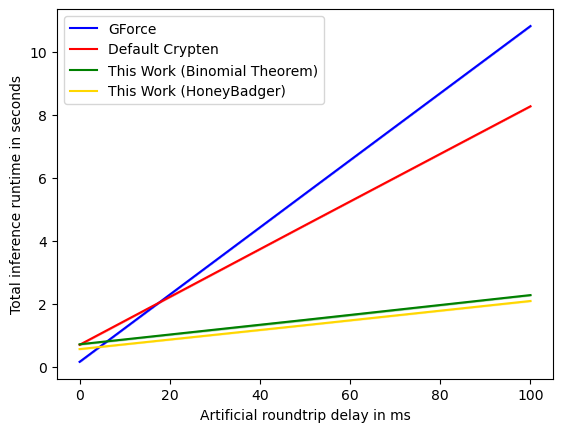

In [108]:
plot_model(models['cifar10'][3], reject=['crypten12'], add_device=False)

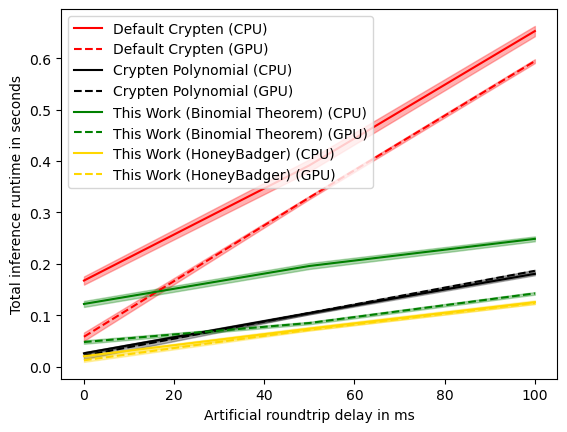

In [109]:
results = get_all_results(models['relus'][0]) + get_all_results(models['relus'][1])
plot_results(results, add_device=True, plot_path="../plots/relus_all.png")

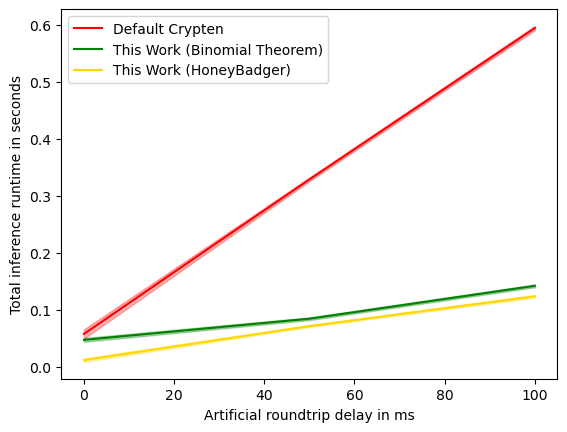

In [110]:
for dataset in datasets:
    for model in models[dataset]:
        plot_model(model , reject=['crypten12'], add_device=False)